## Imports

In [30]:
import os
# Set CUDA_VISIBLE_DEVICES before importing torch so the chosen physical GPU is exposed correctly.
# Use the physical GPU index reported by `nvidia-smi` (e.g. "1" for the second card).

# Now import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
# import holoviews as hv
import tifffile
import careamics
from careamics import CAREamist
from careamics.utils.metrics import scale_invariant_psnr, psnr, avg_range_invariant_psnr
import ramanspy as rpT
import pandas
from typing import List
import xarray as xa
import platform
import subprocess
    
# Diagnostics: confirm available physical GPUs (nvidia-smi) and what PyTorch sees.
# This verifies mapping between physical index (nvidia-smi) and PyTorch visible index.
try:
    smi = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=index,name,memory.total", "--format=csv,noheader"],
        stderr=subprocess.STDOUT
    ).decode().strip()
except Exception:
    smi = "nvidia-smi not available or failed"
print("nvidia-smi GPUs (physical index, name, memory):\n", smi)
print(f"CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")
print(f"Python platform: {platform.platform()}")
print(f"PyTorch version: {torch.__version__}")

# After setting CUDA_VISIBLE_DEVICES='1', physical GPU 1 will appear as cuda:0 to PyTorch.
if torch.cuda.is_available():
    print(f"PyTorch sees {torch.cuda.device_count()} CUDA device(s)")
    device = torch.device("cuda:0")          # use cuda:0 because only the selected physical GPU is visible
    torch.cuda.set_device(0)                 # set default device index within the visible devices
    print(f"Using PyTorch device: {device}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif torch.backends.mps.is_available():
    print("PyTorch sees an Apple Silicon GPU (MPS backend).")
    device = torch.device("mps")
    print(f"Using PyTorch device: {device}")
else:
    print("No CUDA GPUs available to PyTorch (torch.cuda.is_available() == False).")
    print("If you expect GPUs, restart the kernel after changing CUDA_VISIBLE_DEVICES, or launch Jupyter with the env var set:")
    print("  CUDA_VISIBLE_DEVICES=1 jupyter lab  # or jupyter notebook")
    print("Ensure NVIDIA drivers and CUDA are installed and compatible with torch build.")
print(os.getcwd())

# %matplotlib widget
%load_ext autoreload
%autoreload 2

nvidia-smi GPUs (physical index, name, memory):
 nvidia-smi not available or failed
CUDA_VISIBLE_DEVICES=None
Python platform: macOS-26.2-arm64-arm-64bit-Mach-O
PyTorch version: 2.8.0
PyTorch sees an Apple Silicon GPU (MPS backend).
Using PyTorch device: mps
/Users/tom/Developments/Raman/flogen
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


python(2538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [31]:
from typing import List, Optional, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import ramanspy as rp

def sinusoidal_positional_encoding(max_position, d_model, scale=0.1):
    position = np.arange(max_position)[:, np.newaxis]
    # The original formula pos / 10000^(2i/d_model) is equivalent to pos * (1 / 10000^(2i/d_model)).
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((max_position, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe * scale

def wavenumber_positional_encoding(wavenumbers, d_model, scale=0.1):
    """Encode actual wavenumber values instead of indices"""
    position = wavenumbers[:, np.newaxis]  # Use actual wavenumbers
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((len(wavenumbers), d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe * scale

def expand(spectrum: rp.SpectralContainer, pos):
    n_channels = pos.shape[1]  
    expanded = spectrum.spectral_data[..., None]
    pe_broadcast = np.broadcast_to(pos[None, :, :], (spectrum.spectral_data.shape[0], spectrum.spectral_data.shape[1], n_channels))
    result = np.concatenate([expanded, pe_broadcast], axis=-1)
    return result

def scale_signal(
    spectrum: rp.SpectralContainer, scale_factor: float
) -> rp.SpectralContainer:
    """
    Scale spectral intensity by a multiplicative factor, then center.

    Args:
        spectrum: SpectralContainer with spectral data to scale
        scale_factor: Multiplicative scaling factor (e.g., integration_time)

    Returns:
        SpectralContainer with scaled and centered spectral data
    """
    # First scale, then center
    scaled_data = spectrum.spectral_data / scale_factor
    centered_data = scaled_data - np.mean(scaled_data, axis=1, keepdims=True)

    return rp.SpectralContainer(
        spectral_data=centered_data, spectral_axis=spectrum.spectral_axis
    )
def compute_channel_statistics(data):
    data = np.atleast_3d(data)
    n_channels = data.shape[2]
    means = []
    stds = []
    
    for ch in range(n_channels):
        channel_data = data[:, :, ch]
        means.append(float(np.mean(channel_data)))
        stds.append(float(np.std(channel_data)))
        ch_name = "Intensity" if ch == 0 else f"PE_{ch}"
        print(f"Channel {ch} ({ch_name}): Mean = {means[-1]:.4f}, Std = {stds[-1]:.4f}")
    return means, stds
def l2_normalise_spectra(
    spectrum,
):
    """
    L2-normalize spectra for consistent scaling.

    Normalization: normalized = (raw - mean) / norm

    Supports:
    - rp.SpectralContainer (multi-sample or single-sample)
    - np.ndarray (spectral data only)

    Args:
        spectrum: SpectralContainer or np.ndarray with raw spectra
    Returns:
        SpectralContainer if input is SpectralContainer, else np.ndarray
    """
    # Handle SpectralContainer
    if hasattr(spectrum, "spectral_data") and hasattr(spectrum, "spectral_axis"):
        data = spectrum.spectral_data
        print("Data type: spectral container")
        # Compute mean and L2 norm along axis 1 (spectral axis)
        means = np.mean(data, axis=1, keepdims=True)
        norms = np.linalg.norm(data - means, axis=1, keepdims=True)
        
        # Normalize: (raw - mean) / norm
        normalised_data = (data - means) / (norms + 1e-8)  # avoid division by zero
        
        return rp.SpectralContainer(
            spectral_data=normalised_data, spectral_axis=spectrum.spectral_axis
        ), means.squeeze(), norms.squeeze()
    
    # Handle np.ndarray (spectral data only)
    elif isinstance(spectrum, np.ndarray):
        print("Data type: ndarray")
        means = np.mean(spectrum, axis=1, keepdims=True)
        norms = np.linalg.norm(spectrum - means, axis=1, keepdims=True)
        
        return (spectrum - means) / (norms + 1e-8), means.squeeze(), norms.squeeze()
    else:
        raise TypeError("Input must be rp.SpectralContainer or np.ndarray.")
    
def l2_denormalise_spectra(
    spectrum,
    original_means,
    original_norms,
    axis: Optional[int] = None,
):
    """
    Denormalize L2-normalized spectra back to original scale.

    Reverses the L2 normalization: normalized = (raw - mean) / norm
    So: raw = (normalized * norm) + mean

    Supports:
    - rp.SpectralContainer (multi-sample or single-sample)
    - np.ndarray (spectral data only)

    Args:
        spectrum: SpectralContainer or np.ndarray with normalized spectra
        original_means: Mean values used during normalization (from xarray 'l2_means')
        original_norms: L2 norms used during normalization (from xarray 'l2_norms')
        axis: Axis along which to apply denormalization (default: 1 for multi-sample, 0 for single)

    Returns:
        SpectralContainer if input is SpectralContainer, else np.ndarray
    """
    # Convert xarray DataArrays to numpy if needed
    if hasattr(original_means, 'values'):
        original_means = original_means.values
    if hasattr(original_norms, 'values'):
        original_norms = original_norms.values

    # Handle SpectralContainer
    if hasattr(spectrum, "spectral_data") and hasattr(spectrum, "spectral_axis"):
        data = spectrum.spectral_data
        
        # Reshape norms and means for broadcasting: (n_samples,) -> (n_samples, 1)
        if data.ndim == 2 and original_norms.ndim == 1:
            original_norms = original_norms[:, np.newaxis]
            original_means = original_means[:, np.newaxis]
        
        # Denormalize: raw = (normalized * norm) + mean
        denormalised_data = (data * original_norms) + original_means
        
        return rp.SpectralContainer(
            spectral_data=denormalised_data, spectral_axis=spectrum.spectral_axis
        )
    
    # Handle np.ndarray (spectral data only)
    elif isinstance(spectrum, np.ndarray):
        # Reshape for broadcasting if needed
        if spectrum.ndim == 2 and original_norms.ndim == 1:
            original_norms = original_norms[:, np.newaxis]
            original_means = original_means[:, np.newaxis]
        
        return (spectrum * original_norms) + original_means
    else:
        raise TypeError("Input must be rp.SpectralContainer or np.ndarray.")


def normalise_spectra(
        spectrum,
        axis: Optional[int] = None
    ):
        """
        Normalize spectra to zero mean and unit variance for overlay visualization.

        Supports:
        - rp.SpectralContainer (multi-sample or single-sample)
        - np.ndarray (spectral data only)

        Args:
            spectrum: SpectralContainer, single Spectrum, or np.ndarray
            axis: Axis along which to compute statistics (default: 1 for multi-sample, 0 for single spectrum)

        Returns:
            SpectralContainer if input is SpectralContainer, else np.ndarray
        """
        # Handle SpectralContainer
        if hasattr(spectrum, "spectral_data") and hasattr(spectrum, "spectral_axis"):
            data = spectrum.spectral_data
            # Determine axis: 1 for multi-sample, 0 for single spectrum
            if axis is None:
                axis = 1 if data.ndim > 1 else 0
            mean = np.mean(data, axis=axis, keepdims=True)
            std = np.std(data, axis=axis, keepdims=True)
            normalised_data = (data - mean) / (std + 1e-8)
            return rp.SpectralContainer(
                spectral_data=normalised_data,
                spectral_axis=spectrum.spectral_axis
            )
        # Handle np.ndarray (spectral data only)
        elif isinstance(spectrum, np.ndarray):
            if axis is None:
                axis = 1 if spectrum.ndim > 1 else 0
            mean = np.mean(spectrum, axis=axis, keepdims=True)
            std = np.std(spectrum, axis=axis, keepdims=True)
            return (spectrum - mean) / (std + 1e-8)
        else:
            raise TypeError("Input must be rp.SpectralContainer or np.ndarray.")

def compare_spectra(
    containers: List[rp.SpectralContainer],
    n_samples: int = 1,
    width: int = 30,
    height: int = 20,
    overlay: bool = True,
    separate_samples: bool = False,
    titles: Optional[List[str]] = None,
    plot_mean: bool = False,
    alphas: List[float] = None,
    crop: Tuple[float, float] = None
) -> Union[Tuple[Figure, Axes], Tuple[Figure, np.ndarray]]:
    """
    Compare multiple spectral containers with flexible layout options.
    
    Layout modes:
    - overlay=True, separate_samples=False: All containers and all samples on single axes
    - overlay=True, separate_samples=True: All containers on one axes per sample (multiple figures)
    - overlay=False, separate_samples=False: One subplot per container, all samples per subplot
    - overlay=False, separate_samples=True: One figure per sample with one subplot per container
    
    Args:
        containers: List of SpectralContainers to compare
        n_samples: Number of spectra to plot from each container
        width: Figure width in inches
        height: Figure height in inches
        overlay: If True, plot all containers on same axes
        separate_samples: If True, create separate plots for each sample
        titles: List of titles for each container
        plot_mean: If True, plot mean spectrum for each container
    
    Returns:
        Tuple of (figure, axes) objects
    """
    n_containers = len(containers)

    if titles is not None and len(titles) != n_containers:
        raise ValueError(
            f"Number of titles ({len(titles)}) must match number of containers ({n_containers})"
        )
        # Prepare cropped data if crop is specified
    cropped_containers = []
    for container in containers:
        if crop is not None:
            # Find indices within the crop range
            mask = (container.spectral_axis >= crop[0]) & (container.spectral_axis <= crop[1])
            cropped_axis = container.spectral_axis[mask]
            cropped_data = container.spectral_data[..., mask]
            cropped_containers.append(
                rp.SpectralContainer(spectral_data=cropped_data, spectral_axis=cropped_axis)
            )
        else:
            cropped_containers.append(container)

    containers = cropped_containers
    
    if overlay:
        if separate_samples:
            # Each sample gets its own figure with all containers overlaid
            for sample_idx in range(n_samples):
                fig, ax = plt.subplots(figsize=(width, height))
                ax.set_title(f"Spectral Comparison - Sample {sample_idx}")
                ax.set_xlabel("Raman Shift (cm⁻¹)")
                ax.set_ylabel("Intensity (a.u.)")
                ax.grid(True, alpha=0.3)
                
                for container_idx, container in enumerate(containers):
                    container_label = titles[container_idx] if titles else f"Container {container_idx}"
                    ax.plot(
                        container.spectral_axis,
                        container.spectral_data[sample_idx],
                        alpha=alphas[container_idx] if alphas else 0.9,
                        label=container_label,
                    )
                
                ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
                plt.tight_layout()
                plt.show()
            
            # Return last figure/axes for compatibility
            return fig, ax
        else:
            # Single figure with all containers and all samples overlaid
            fig, ax = plt.subplots(figsize=(width, height))
            ax.set_title("Spectral Comparison")
            ax.set_xlabel("Raman Shift (cm⁻¹)")
            ax.set_ylabel("Intensity (a.u.)")
            ax.grid(True, alpha=0.3)

            for container_idx, container in enumerate(containers):
                container_label = titles[container_idx] if titles else f"Container {container_idx}"
                
                for sample_idx in range(n_samples):
                    label = f"{container_label} - Spectrum {sample_idx}" if n_samples > 1 else container_label
                    ax.plot(
                        container.spectral_axis,
                        container.spectral_data[sample_idx],
                        label=label,
                        alpha=alphas[container_idx] if alphas else 0.7,
                    )
                
                if plot_mean:
                    ax.plot(
                        container.spectral_axis,
                        container.spectral_data[:n_samples].mean(axis=0),
                        label=f"{container_label} - Mean",
                        linestyle="--",
                        linewidth=2,
                    )

            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
            plt.tight_layout()
            return fig, ax
    else:
        if separate_samples:
            # Each sample gets its own figure with one subplot per container
            for sample_idx in range(n_samples):
                fig, axes = plt.subplots(
                    nrows=n_containers,
                    ncols=1,
                    figsize=(width, height),
                    squeeze=False,
                )

                for container_idx, container in enumerate(containers):
                    ax = axes[container_idx, 0]
                    title = titles[container_idx] if titles else f"Container {container_idx}"
                    ax.set_title(f"{title} - Sample {sample_idx}")
                    ax.set_xlabel("Raman Shift (cm⁻¹)")
                    ax.set_ylabel("Intensity (a.u.)")
                    ax.grid(True, alpha=0.3)
                    
                    ax.plot(
                        container.spectral_axis,
                        container.spectral_data[sample_idx],
                        label=f"Spectrum {sample_idx}",
                        alpha=alphas[container_idx] if alphas else 0.7,
                    )
                    
                    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
                
                plt.tight_layout()
                plt.show()
            
            # Return last figure/axes for compatibility
            return fig, axes.flatten()
        else:
            # Single figure with one subplot per container, all samples per subplot
            fig, axes = plt.subplots(
                nrows=n_containers,
                ncols=1,
                figsize=(width, height),
                squeeze=False,
            )

            for container_idx, container in enumerate(containers):
                ax = axes[container_idx, 0]
                title = titles[container_idx] if titles else f"Container {container_idx}"
                ax.set_title(title)
                ax.set_xlabel("Raman Shift (cm⁻¹)")
                ax.set_ylabel("Intensity (a.u.)")
                ax.grid(True, alpha=0.3)

                for sample_idx in range(n_samples):
                    ax.plot(
                        container.spectral_axis,
                        container.spectral_data[sample_idx],
                        label=f"Spectrum {sample_idx}",
                        alpha=alphas[container_idx] if alphas else 0.7,
                    )
                
                if plot_mean:
                    ax.plot(
                        container.spectral_axis,
                        container.spectral_data[:n_samples].mean(axis=0),
                        label="Mean",
                        linestyle="--",
                        linewidth=2,
                        color="black",
                    )

                ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
            
            plt.tight_layout()
            return fig, axes.flatten()

In [33]:
import sys
sys.path.insert(0, "../RamaN2V")
from ATCCLoader import load_data


from flogen import (
    SyntheticConfig, 
    RamanLibrary, 
    SyntheticBleachingDataset
)

# 1. Load real ATCC data
atcc_dataset = load_data("../RamaN2V/data/ATCC/")
atcc_xr = atcc_dataset.to_xarray(
    crop=(400, 1800),
    remove_outliers=True,
    despike=True,
)

# 2. Create Raman library
target_wavenumbers = atcc_xr['wavenumber'].values

raman_library = RamanLibrary(
    target_wavenumbers=target_wavenumbers,
    atcc_weight=0.7,
    seed=42,
)

# Add ATCC late frames
raman_library.add_from_atcc_xarray(
    atcc_xr,
    late_time=['15s'],  # Use longest integration time
    baseline_correct=True,
)


# raman_library.add_from_ramanspy("./data/ramanspy_bacteria")

print(f"Raman library size: {len(raman_library)} spectra")

# 3. Configure synthetic generation
config = SyntheticConfig(
    n_samples=10000,
    integration_times=['0.01s', '0.1s', '1s', '10s', '15s'],
    n_fluorophores=3,
    shared_bases=True,
    snr_range=(15.0, 50.0),
    seed=42,
)

# 4. Generate synthetic dataset
generator = SyntheticBleachingDataset(config, raman_library)
synthetic_ds = generator.generate()

# 5. Save
generator.save("synthetic_bleaching_10k.nc")

# 6. Verify structure matches ATCCLoader
print("\nDataset structure:")
print(synthetic_ds)

Found 11250 spectrum files
  -> New calibration set detected! (Set #0)
  -> New calibration set detected! (Set #1)
  -> New calibration set detected! (Set #2)

Successfully loaded 11250 spectra

Loaded 9 strains:
  Strain 12228 (Staphylococcus epidermidis, G+): 1250 spectra
  Strain 19606 (Acinetobacter baumannii, G-): 1250 spectra
  Strain 25922 (Escherichia coli, G-): 1250 spectra
  Strain 25923 (Staphylococcus aureus, G+): 1250 spectra
  Strain 27853 (Pseudomonas aeruginosa, G-): 1250 spectra
  Strain 29212 (Enterococcus faecalis, G+): 1250 spectra
  Strain 29213 (Staphylococcus aureus, G+): 1250 spectra
  Strain 35218 (Escherichia coli, G-): 1250 spectra
  Strain 700603 (Klebsiella Pneumoniae, G-): 1250 spectra

=== Outlier Removal Summary ===
Strain 12228: Orig: 375, Rm: 8 (Sat: 1, Drop: 7)
Strain 19606: Orig: 250, Rm: 7 (Sat: 0, Drop: 7)
Strain 25922: Orig: 250, Rm: 6 (Sat: 0, Drop: 6)
Strain 25923: Orig: 250, Rm: 7 (Sat: 2, Drop: 5)
Strain 27853: Orig: 250, Rm: 4 (Sat: 0, Drop: 

/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/ramanspy/core.py:35: SyntaxWarning: invalid escape sequence '\ '
  The Raman wavenumber axis (in cm\ :sup:`-1`). Order and length must match the last dimension of ``spectral_data``.


TypeError: object of type 'numpy.float64' has no len()

In [11]:


print("Extracting 1s and 10s Integration Time Data")

# Extract specific integration times from the loaded dataset
# cropped_axis = ds['wavenumber'].sel(wavenumber=slice(400, 1800))
# cropped_mask = (ds['wavenumber'] >= 400) & (ds['wavenumber'] <= 1800)
# strain_mask = synthetic_ds['strain_id'] == 27853
X_0pt1s = synthetic_ds.sel(integration_time='0.1s')
X_1s = synthetic_ds.sel(integration_time='1s')
X_10s = synthetic_ds.sel(integration_time='10s')
X_15s = synthetic_ds.sel(integration_time='15s')
# # Extract normalized intensity data
# X_0pt1s = very_low_snr['intensity_normalised'].values
# X_1s = low_snr['intensity_normalised'].values  # (n_samples, n_wavenumbers)
# X_10s = high_snr['intensity_normalised'].values

# Create species labels (map species names to integers)
species_names = X_1s['species'].values
unique_species = np.unique(species_names)
species_to_int = {name: i for i, name in enumerate(unique_species)}
y = np.array([species_to_int[name] for name in species_names])

print(f"Data shapes: 1s={X_1s.dims}, 10s={X_10s.dims}")
print(f"Number of classes: {len(unique_species)}")
print(f"Species mapping:")
for species, idx in species_to_int.items():
    count = (y == idx).sum()
    print(f"  {idx}: {species} ({count} samples)")

Extracting 1s and 10s Integration Time Data
Data shapes: 1s=FrozenMappingWarningOnValuesAccess({'sample': 10000, 'wavenumber': 736, 'fluorophore': 3}), 10s=FrozenMappingWarningOnValuesAccess({'sample': 10000, 'wavenumber': 736, 'fluorophore': 3})
Number of classes: 7
Species mapping:
  0: Acinetobacter baumannii (1088 samples)
  1: Enterococcus faecalis (1078 samples)
  2: Escherichia coli (2284 samples)
  3: Klebsiella Pneumoniae (1088 samples)
  4: Pseudomonas aeruginosa (1114 samples)
  5: Staphylococcus aureus (2246 samples)
  6: Staphylococcus epidermidis (1102 samples)


## Fluorescence Plotting Functions

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from typing import Optional, List, Tuple
from matplotlib.figure import Figure


def get_fluorophore_contribution(
    ds: xr.Dataset,
    sample_idx: int,
    fluorophore_idx: int,
    time_seconds: Optional[float] = None,
) -> np.ndarray:
    """
    Compute the contribution of a single fluorophore at a given time.
    
    F_i(ν,t) = w_i · B_i(ν) · exp(-λ_i · t)
    
    Parameters
    ----------
    ds : xr.Dataset
        Synthetic dataset
    sample_idx : int
        Sample index
    fluorophore_idx : int
        Fluorophore index (0, 1, 2, ...)
    time_seconds : float, optional
        Time in seconds. If None, returns at t=0 (no decay)
    
    Returns
    -------
    np.ndarray
        Fluorophore contribution spectrum (n_wavenumbers,)
    """
    # Get parameters
    w_i = ds['abundances_gt'].isel(sample=sample_idx, fluorophore=fluorophore_idx).values
    λ_i = ds['decay_rates_gt'].isel(sample=sample_idx, fluorophore=fluorophore_idx).values
    
    # Get basis (shared or per-sample)
    if 'sample' in ds['fluorophore_bases_gt'].dims:
        B_i = ds['fluorophore_bases_gt'].isel(sample=sample_idx, fluorophore=fluorophore_idx).values
    else:
        B_i = ds['fluorophore_bases_gt'].isel(fluorophore=fluorophore_idx).values
    
    # Compute decay
    if time_seconds is None:
        time_seconds = 0.0
    decay = np.exp(-λ_i * time_seconds)
    
    return w_i * B_i * decay


def get_total_fluorescence(
    ds: xr.Dataset,
    sample_idx: int,
    time_seconds: float,
) -> np.ndarray:
    """
    Compute total fluorescence at a given time.
    
    F(ν,t) = Σᵢ wᵢ · Bᵢ(ν) · exp(-λᵢ · t)
    """
    n_fluorophores = ds.dims['fluorophore']
    total = np.zeros(ds.dims['wavenumber'])
    
    for i in range(n_fluorophores):
        total += get_fluorophore_contribution(ds, sample_idx, i, time_seconds)
    
    return total


def get_full_decomposition(
    ds: xr.Dataset,
    sample_idx: int,
    time_seconds: float,
) -> dict:
    """
    Get all components of the decomposition at a given time.
    
    Returns
    -------
    dict with keys:
        - 'raman': s(ν)
        - 'fluorophore_0', 'fluorophore_1', ...: individual F_i(ν,t)
        - 'total_fluorescence': Σ F_i(ν,t)
        - 'reconstructed': s(ν) + Σ F_i(ν,t)
        - 'observed_clean': from dataset
        - 'observed_noisy': from dataset
        - 'wavenumbers': ν axis
        - 'decay_rates': λ values
        - 'abundances': w values
        - 'time_constants': τ = 1/λ
    """
    n_fluorophores = ds.dims['fluorophore']
    wavenumbers = ds['wavenumber'].values
    
    # Get time index
    time_values = ds['time_seconds'].values
    time_idx = np.argmin(np.abs(time_values - time_seconds))
    actual_time = time_values[time_idx]
    
    # Raman
    raman = ds['raman_gt'].isel(sample=sample_idx).values
    
    # Individual fluorophore contributions
    fluorophores = {}
    total_fluor = np.zeros_like(raman)
    
    for i in range(n_fluorophores):
        contrib = get_fluorophore_contribution(ds, sample_idx, i, actual_time)
        fluorophores[f'fluorophore_{i}'] = contrib
        total_fluor += contrib
    
    # Reconstructed
    reconstructed = raman + total_fluor
    
    # Observed
    observed_clean = ds['intensity_clean'].isel(sample=sample_idx, integration_time=time_idx).values
    observed_noisy = ds['intensity_raw'].isel(sample=sample_idx, integration_time=time_idx).values
    
    # Parameters
    decay_rates = ds['decay_rates_gt'].isel(sample=sample_idx).values
    abundances = ds['abundances_gt'].isel(sample=sample_idx).values
    
    result = {
        'raman': raman,
        'total_fluorescence': total_fluor,
        'reconstructed': reconstructed,
        'observed_clean': observed_clean,
        'observed_noisy': observed_noisy,
        'wavenumbers': wavenumbers,
        'time_seconds': actual_time,
        'decay_rates': decay_rates,
        'abundances': abundances,
        'time_constants': 1.0 / decay_rates,
    }
    result.update(fluorophores)
    
    return result


def plot_decomposition(
    ds: xr.Dataset,
    sample_idx: int,
    time_seconds: float,
    figsize: Tuple[int, int] = (14, 10),
    show_noisy: bool = True,
) -> Figure:
    """
    Plot the full decomposition for a single sample at a given time.
    
    Shows:
    - Top: Full spectrum with components stacked
    - Bottom left: Individual fluorophore contributions
    - Bottom right: Residual (observed - reconstructed)
    """
    decomp = get_full_decomposition(ds, sample_idx, time_seconds)
    wn = decomp['wavenumbers']
    n_fluorophores = ds.dims['fluorophore']
    
    fig = plt.figure(figsize=figsize)
    
    # Top panel: Full decomposition
    ax1 = fig.add_subplot(2, 2, (1, 2))
    
    if show_noisy:
        ax1.plot(wn, decomp['observed_noisy'], 'gray', alpha=0.5, 
                 label='Observed (noisy)', linewidth=0.5)
    
    ax1.plot(wn, decomp['observed_clean'], 'k-', alpha=0.8, 
             label='Observed (clean)', linewidth=1.5)
    ax1.plot(wn, decomp['reconstructed'], 'r--', alpha=0.8, 
             label='Reconstructed', linewidth=1.5)
    ax1.plot(wn, decomp['raman'], 'b-', alpha=0.7, 
             label='Raman (GT)', linewidth=1.5)
    ax1.plot(wn, decomp['total_fluorescence'], 'orange', alpha=0.7, 
             label='Total Fluorescence', linewidth=1.5)
    
    ax1.set_xlabel('Wavenumber (cm⁻¹)')
    ax1.set_ylabel('Intensity')
    ax1.set_title(f'Sample {sample_idx} at t = {decomp["time_seconds"]:.2f}s')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Bottom left: Individual fluorophores
    ax2 = fig.add_subplot(2, 2, 3)
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_fluorophores))
    
    for i in range(n_fluorophores):
        τ = decomp['time_constants'][i]
        w = decomp['abundances'][i]
        ax2.plot(wn, decomp[f'fluorophore_{i}'], color=colors[i],
                 label=f'F{i+1}: τ={τ:.3f}s, w={w:.1f}', linewidth=1.5)
    
    ax2.set_xlabel('Wavenumber (cm⁻¹)')
    ax2.set_ylabel('Intensity')
    ax2.set_title('Individual Fluorophore Contributions')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Bottom right: Residual
    ax3 = fig.add_subplot(2, 2, 4)
    
    residual = decomp['observed_clean'] - decomp['reconstructed']
    ax3.plot(wn, residual, 'k-', linewidth=1)
    ax3.axhline(0, color='r', linestyle='--', alpha=0.5)
    ax3.fill_between(wn, residual, 0, alpha=0.3)
    
    rmse = np.sqrt(np.mean(residual**2))
    ax3.set_xlabel('Wavenumber (cm⁻¹)')
    ax3.set_ylabel('Residual')
    ax3.set_title(f'Residual (RMSE = {rmse:.4f})')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_temporal_decomposition(
    ds: xr.Dataset,
    sample_idx: int,
    figsize: Tuple[int, int] = (14, 8),
) -> Figure:
    """
    Plot decomposition across all time points for a single sample.
    
    Shows how fluorescence decays while Raman stays constant.
    """
    time_values = ds['time_seconds'].values
    wn = ds['wavenumber'].values
    n_times = len(time_values)
    n_fluorophores = ds.dims['fluorophore']
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Color maps
    time_colors = plt.cm.plasma(np.linspace(0, 0.9, n_times))
    fluor_colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_fluorophores))
    
    # Top left: Observed spectra over time
    ax = axes[0, 0]
    for t_idx, t in enumerate(time_values):
        spectrum = ds['intensity_clean'].isel(sample=sample_idx, integration_time=t_idx).values
        ax.plot(wn, spectrum, color=time_colors[t_idx], alpha=0.8, 
                label=f't={t:.2f}s')
    
    ax.plot(wn, ds['raman_gt'].isel(sample=sample_idx).values, 'k--', 
            linewidth=2, label='Raman (GT)')
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.set_ylabel('Intensity')
    ax.set_title('Observed Spectra Over Time')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Top right: Total fluorescence over time
    ax = axes[0, 1]
    for t_idx, t in enumerate(time_values):
        fluor = get_total_fluorescence(ds, sample_idx, t)
        ax.plot(wn, fluor, color=time_colors[t_idx], alpha=0.8,
                label=f't={t:.2f}s')
    
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.set_ylabel('Intensity')
    ax.set_title('Total Fluorescence Decay')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Bottom left: Individual fluorophore decay curves
    ax = axes[1, 0]
    
    decay_rates = ds['decay_rates_gt'].isel(sample=sample_idx).values
    abundances = ds['abundances_gt'].isel(sample=sample_idx).values
    
    # Get basis spectra means for amplitude
    for i in range(n_fluorophores):
        if 'sample' in ds['fluorophore_bases_gt'].dims:
            B_i = ds['fluorophore_bases_gt'].isel(sample=sample_idx, fluorophore=i).values
        else:
            B_i = ds['fluorophore_bases_gt'].isel(fluorophore=i).values
        
        # Mean intensity over time
        intensities = []
        for t in time_values:
            contrib = abundances[i] * B_i * np.exp(-decay_rates[i] * t)
            intensities.append(contrib.mean())
        
        τ = 1.0 / decay_rates[i]
        ax.plot(time_values, intensities, 'o-', color=fluor_colors[i],
                label=f'F{i+1}: τ={τ:.3f}s', linewidth=2, markersize=6)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean Fluorescence Intensity')
    ax.set_title('Fluorophore Decay Curves')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    
    # Bottom right: Basis spectra (unscaled)
    ax = axes[1, 1]
    
    for i in range(n_fluorophores):
        if 'sample' in ds['fluorophore_bases_gt'].dims:
            B_i = ds['fluorophore_bases_gt'].isel(sample=sample_idx, fluorophore=i).values
        else:
            B_i = ds['fluorophore_bases_gt'].isel(fluorophore=i).values
        
        τ = 1.0 / decay_rates[i]
        ax.plot(wn, B_i, color=fluor_colors[i], linewidth=1.5,
                label=f'B{i+1} (τ={τ:.3f}s)')
    
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.set_ylabel('Intensity (normalized)')
    ax.set_title('Fluorophore Basis Spectra')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Sample {sample_idx} - Temporal Decomposition', fontsize=12, y=1.02)
    plt.tight_layout()
    return fig


def plot_stacked_decomposition(
    ds: xr.Dataset,
    sample_idx: int,
    time_seconds: float,
    figsize: Tuple[int, int] = (12, 6),
) -> Figure:
    """
    Plot stacked area chart showing how components sum to total.
    """
    decomp = get_full_decomposition(ds, sample_idx, time_seconds)
    wn = decomp['wavenumbers']
    n_fluorophores = ds.dims['fluorophore']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Stack: Raman at bottom, then fluorophores
    colors = ['steelblue'] + list(plt.cm.Oranges(np.linspace(0.3, 0.8, n_fluorophores)))
    
    # Collect components for stacking
    components = [decomp['raman']]
    labels = ['Raman']
    
    for i in range(n_fluorophores):
        τ = decomp['time_constants'][i]
        components.append(decomp[f'fluorophore_{i}'])
        labels.append(f'Fluor {i+1} (τ={τ:.2f}s)')
    
    # Stack plot
    ax.stackplot(wn, *components, labels=labels, colors=colors, alpha=0.8)
    
    # Overlay observed
    ax.plot(wn, decomp['observed_clean'], 'k-', linewidth=2, 
            label='Observed (clean)', alpha=0.8)
    
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Sample {sample_idx} at t={time_seconds:.2f}s - Stacked Decomposition')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

/var/folders/3x/hvpt0x5d7j7d_pc25_67tyxh0000gn/T/ipykernel_29034/3558539532.py:94: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_fluorophores = ds.dims['fluorophore']
/var/folders/3x/hvpt0x5d7j7d_pc25_67tyxh0000gn/T/ipykernel_29034/3558539532.py:159: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_fluorophores = ds.dims['fluorophore']


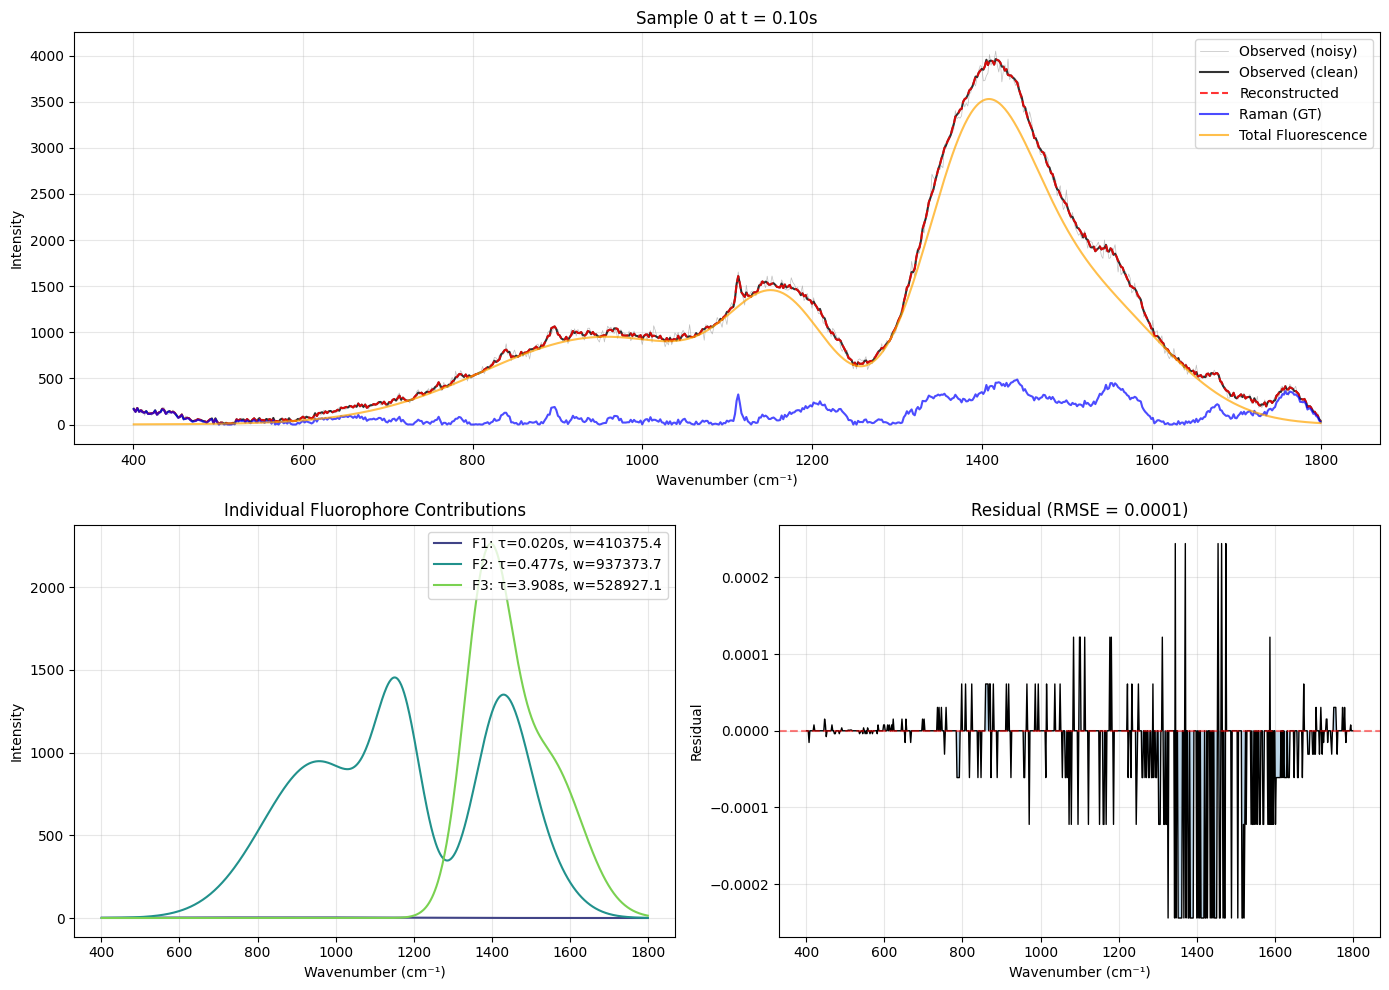

/var/folders/3x/hvpt0x5d7j7d_pc25_67tyxh0000gn/T/ipykernel_29034/3558539532.py:233: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_fluorophores = ds.dims['fluorophore']
/var/folders/3x/hvpt0x5d7j7d_pc25_67tyxh0000gn/T/ipykernel_29034/3558539532.py:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_fluorophores = ds.dims['fluorophore']
/var/folders/3x/hvpt0x5d7j7d_pc25_67tyxh0000gn/T/ipykernel_29034/3558539532.py:64: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access

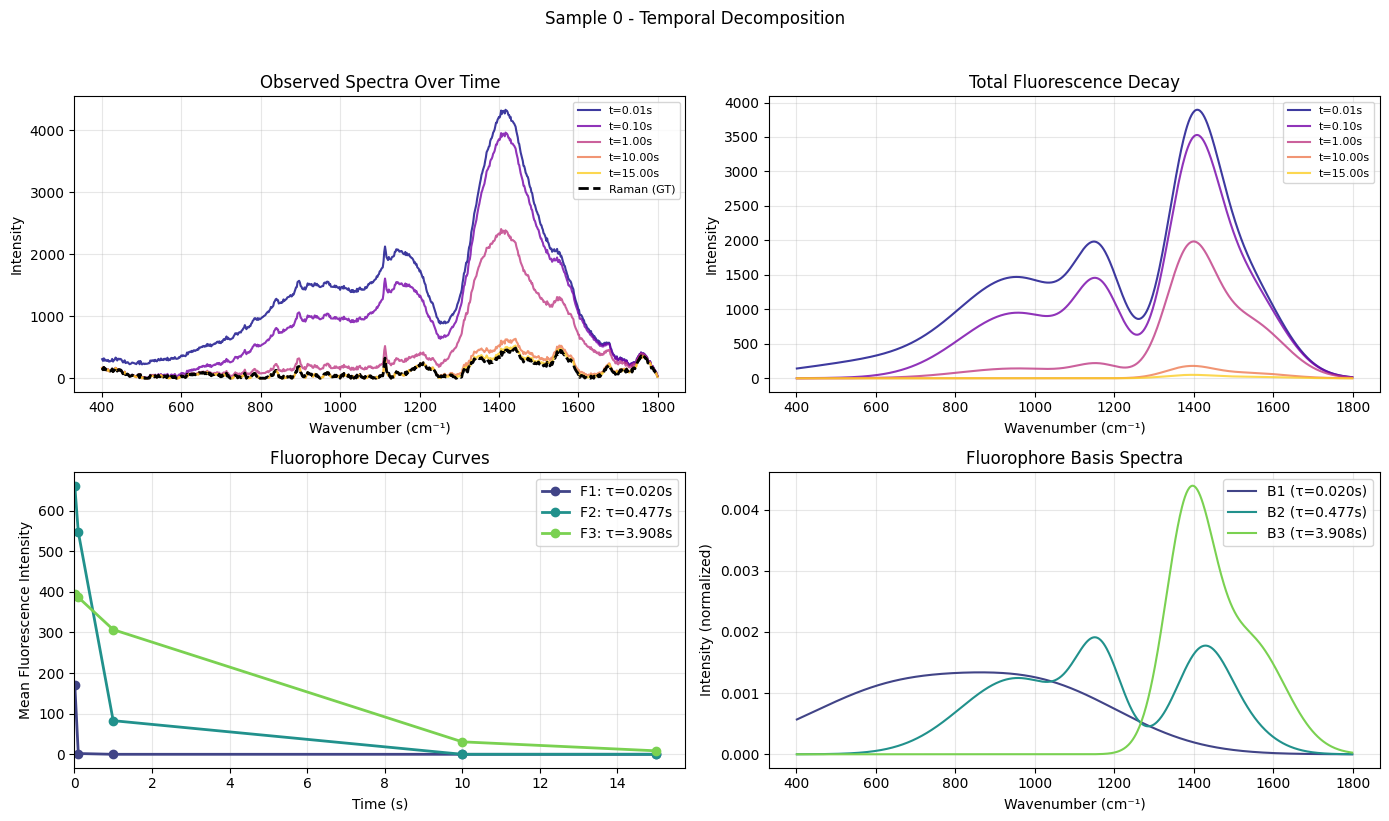

/var/folders/3x/hvpt0x5d7j7d_pc25_67tyxh0000gn/T/ipykernel_29034/3558539532.py:334: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_fluorophores = ds.dims['fluorophore']


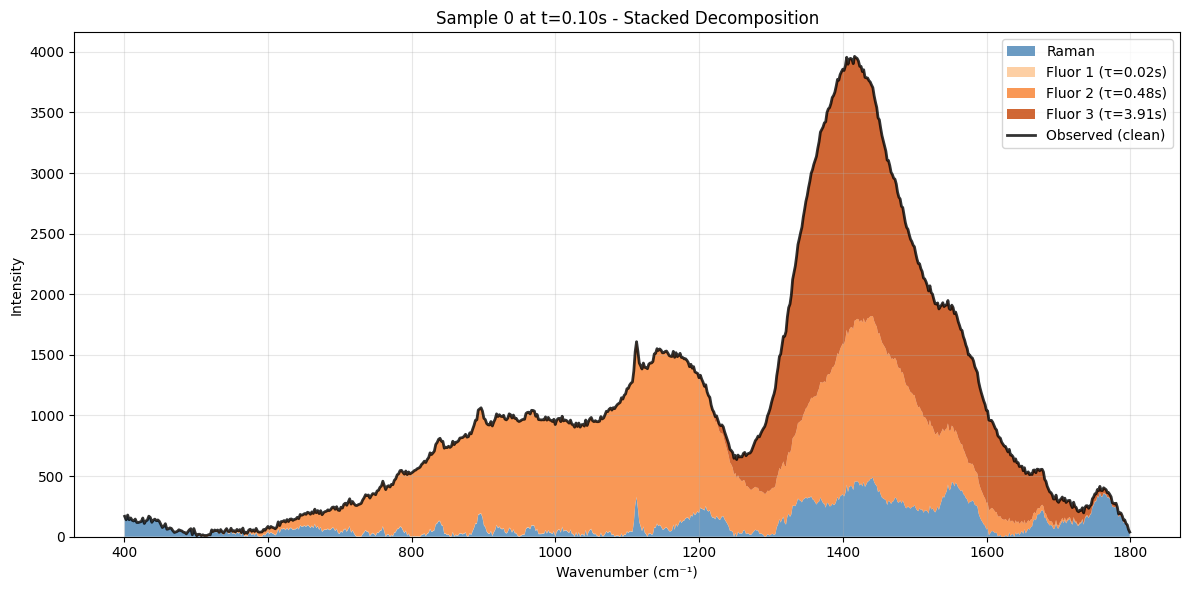

Decay rates (λ): [50.12813     2.0984657   0.25586015]
Time constants (τ): [0.01994888 0.47653866 3.908385  ]
Abundances (w): [410375.44 937373.7  528927.1 ]


In [25]:
# # Load your synthetic dataset
# synthetic_ds = xr.open_dataset('synthetic_bleaching.nc')

# 1. Plot full decomposition for sample 0 at t=0.5s
fig = plot_decomposition(synthetic_ds, sample_idx=0, time_seconds=0.5)
plt.show()

# 2. Plot temporal evolution for sample 0
fig = plot_temporal_decomposition(synthetic_ds, sample_idx=0)
plt.show()

# 3. Plot stacked decomposition
fig = plot_stacked_decomposition(synthetic_ds, sample_idx=0, time_seconds=0.1)
plt.show()

# 4. Get individual fluorophore contribution manually
sample_idx = 0
time_s = 0.5

# Fluorophore 0 (fastest decay)
F0 = get_fluorophore_contribution(synthetic_ds, sample_idx, fluorophore_idx=0, time_seconds=time_s)

# All components
decomp = get_full_decomposition(synthetic_ds, sample_idx, time_s)
print(f"Decay rates (λ): {decomp['decay_rates']}")
print(f"Time constants (τ): {decomp['time_constants']}")
print(f"Abundances (w): {decomp['abundances']}")